# Calculate and verify ETABS earth pressure (non-uniform pressure)

In [410]:

from dataclasses import dataclass

@dataclass
class SoilLateralPressureParameters:
    # units are in meters and kN

    etabs_base_level: float = -5.0

    # all heights are mesured from etabs base level
    water_table_height: float = 6.0
    wall_height: float = 10.0
    soil_total_height: float = 16.0
    
    # Loads and coefficients
    surcharge_load: float = 20.0  # kN/m²

    # local axe 3 direction = 1 for same load direction, -1 for opposite load direction
    local_axe3_direction: int = 1  # 1 or -1
    
    # Soil properties
    soil_unit_weight: float = 20.0  # kN/m³
    soil_submerged_unit_weight: float = 10.0  # kN/m³
    water_unit_weight: float = 10.0  # kN/m³
    soil_lateral_pressure_coefficient: float = 0.5


def min_pressure(params: SoilLateralPressureParameters) -> float:
    # Calculate the minimum lateral pressure at top of the wall
    if params.water_table_height <= params.wall_height:
        min_pressure = params.surcharge_load * params.soil_lateral_pressure_coefficient + \
            params.soil_unit_weight * (params.soil_total_height - params.wall_height) * \
            params.soil_lateral_pressure_coefficient
        
    elif params.water_table_height > params.wall_height:
        min_pressure = params.surcharge_load * params.soil_lateral_pressure_coefficient + \
            params.soil_unit_weight * (params.soil_total_height - params.water_table_height) * \
            params.soil_lateral_pressure_coefficient + \
            params.soil_submerged_unit_weight * (params.water_table_height - params.wall_height) * \
            params.soil_lateral_pressure_coefficient + \
            params.water_unit_weight * (params.water_table_height - params.wall_height)
    return min_pressure * params.local_axe3_direction # kN/m²

def max_pressure(params: SoilLateralPressureParameters) -> float:
    # Calculate the maximum lateral pressure at bottom of the wall
    if params.water_table_height <= 0.0:
        max_pressure = abs(min_pressure(params)) + \
            params.soil_unit_weight * params.wall_height * params.soil_lateral_pressure_coefficient
    elif params.water_table_height < params.wall_height:
        max_pressure = abs(min_pressure(params)) + \
            params.soil_unit_weight * (params.wall_height - params.water_table_height) * params.soil_lateral_pressure_coefficient + \
            params.soil_submerged_unit_weight * params.water_table_height * params.soil_lateral_pressure_coefficient + \
            params.water_unit_weight * params.water_table_height
    elif params.water_table_height >= params.wall_height:
        max_pressure = abs(min_pressure(params)) + \
            params.soil_submerged_unit_weight * params.wall_height * params.soil_lateral_pressure_coefficient + \
            params.water_unit_weight * params.wall_height
    return max_pressure * params.local_axe3_direction # kN/m²



In [411]:
params = SoilLateralPressureParameters(
    etabs_base_level=-5.0,
    water_table_height=6.0,
    wall_height=10.0,
    soil_total_height=16.0,
    surcharge_load=20.0,
    local_axe3_direction=-1,
    soil_unit_weight=20.0,
    soil_submerged_unit_weight=10.0,
    water_unit_weight=10.0,
    soil_lateral_pressure_coefficient=0.5
)

print(f'min. soil pressure = {min_pressure(params)} kN/m² at height = {params.wall_height} m from base level (at top of the wall)')
print(f'max. soil pressure = {max_pressure(params)} kN/m² at level = {params.etabs_base_level} m (at bottom of the wall)')


min. soil pressure = -70.0 kN/m² at height = 10.0 m from base level (at top of the wall)
max. soil pressure = -200.0 kN/m² at level = -5.0 m (at bottom of the wall)


# Calculate ETABS Parameters for soil lateral pressure

In [412]:

def calculate_etabs_parameters(params: SoilLateralPressureParameters) -> tuple:
    # calculate the C and D parameters for ETABS
    # Pressure = C * Z + D
    C = (min_pressure(params) - max_pressure(params)) / params.wall_height
    D = max_pressure(params) - C * params.etabs_base_level
    return (C, D)

C , D = calculate_etabs_parameters(params)
print(f'C = {C} kN/m²/m, D = {D} kN/m²')

# Calculate the pressure at any level
max_pressure = C * (params.etabs_base_level) + D
min_pressure = C * (params.etabs_base_level + params.wall_height) + D
print(f'min. soil pressure = {min_pressure} kN/m² at level = {params.etabs_base_level + params.wall_height} m')
print(f'max. soil pressure = {max_pressure} kN/m² at level = {params.etabs_base_level} m')

C = 13.0 kN/m²/m, D = -135.0 kN/m²
min. soil pressure = -70.0 kN/m² at level = 5.0 m
max. soil pressure = -200.0 kN/m² at level = -5.0 m


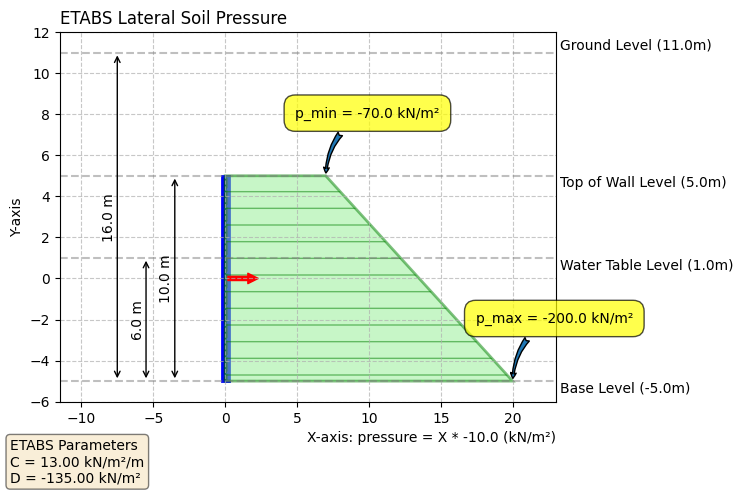

In [413]:
# Plot the lateral soil pressure distribution

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.path as mpath

fig, ax = plt.subplots()

# Create rectangles using Matplotlib's Rectangle patch
x = 0.0
y = params.etabs_base_level
width = 0.5
height = params.wall_height
rect1 = mpatches.Rectangle((x-width/2.0, y), width, height, facecolor='darkblue', edgecolor='blue', hatch='//', linewidth=2)
ax.add_patch(rect1)

sc = 10.0 # scale factor for pressure values
max_pressure = abs(max_pressure)
min_pressure = abs(min_pressure)
# Define the polygon vertices
Path = mpath.Path
path_data = [
    (Path.MOVETO, (x, y)),      # Starting point
    (Path.LINETO, (x + max_pressure / sc , y)),      # Bottom right
    (Path.LINETO, (x + min_pressure / sc, y + height)),      # Top right
    (Path.LINETO, (x, y + height)),      # Top left
    (Path.CLOSEPOLY, (x, y)),   # Close the polygon
]

# Create the path
codes, verts = zip(*path_data)
path = mpath.Path(verts, codes)

# Create a patch with hatching
patch = mpatches.PathPatch(
    path, 
    facecolor='lightgreen',
    edgecolor='green',
    hatch='-',
    alpha=0.5,
    linewidth=2
)
ax.add_patch(patch)


# Add annotations for pressure values
ax.annotate(f'p_max = {params.local_axe3_direction * max_pressure:.1f} kN/m²', 
            xy=(x + max_pressure / sc, y),
            xytext=(30, 40),
            textcoords='offset points',
            ha='center',
            va='bottom',
            bbox=dict(boxstyle='round,pad=0.8', fc='yellow', alpha=0.7),
            arrowprops=dict(arrowstyle='fancy',
            connectionstyle='arc3,rad=0.3'))

ax.annotate(f'p_min = {params.local_axe3_direction * min_pressure:.1f} kN/m²', 
            xy=(x + min_pressure / sc, y + height),
            xytext=(30, 40),
            textcoords='offset points',
            ha='center',
            va='bottom',
            bbox=dict(boxstyle='round,pad=0.8', fc='yellow', alpha=0.7),
            arrowprops=dict(arrowstyle='fancy',
            connectionstyle='arc3,rad=0.3'))



# Add horizontal lines with text
levels = {
    params.etabs_base_level: 'Base Level',
    params.etabs_base_level + params.wall_height: 'Top of Wall Level',
    params.etabs_base_level + params.water_table_height: 'Water Table Level',
    params.etabs_base_level + params.soil_total_height: 'Ground Level'
}

for level, text in levels.items():
    ax.axhline(y=level, color='gray', linestyle='--', alpha=0.5)
    ax.text(max_pressure / sc + 3.3, level, f'{text} ({level:.1f}m)', 
            verticalalignment='bottom' if 'Ground' in text else 'top',
            horizontalalignment='left')


# Add dimension lines from base level
dim_x = - min_pressure / sc / 2  # x-position for dimension lines
dim_offset = 2  # Offset for dimension text
for indx , (level, text) in enumerate(levels.items()):
    if level == params.etabs_base_level:  # Skip base level itself
        continue

    height = level - params.etabs_base_level
    mid_point = params.etabs_base_level + height/2
    
    # Draw vertical dimension line with arrows on both ends
    ax.annotate('',
                xy=(dim_x - dim_offset * (indx-1), params.etabs_base_level),
                xytext=(dim_x - dim_offset * (indx-1), level),
                arrowprops=dict(arrowstyle='<->'))
    
    # Add dimension text
    ax.text(dim_x - dim_offset * (indx-1) - 0.1, mid_point, 
            f'{height:.1f} m',
            rotation=90,
            verticalalignment='center',
            horizontalalignment='right')
        


# Add local axe 3 direction
arrow = mpatches.FancyArrowPatch((0,params.etabs_base_level + params.wall_height/2), 
                                 (-2.5 * params.local_axe3_direction, params.etabs_base_level + params.wall_height/2),
                                 mutation_scale=15, color='red')
ax.add_patch(arrow)

textstr = '\n'.join((
    f'ETABS Parameters',
    f'C = {C:.2f} kN/m²/m',
    f'D = {D:.2f} kN/m²',
))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(-0.1, -0.1, 
        textstr, transform=ax.transAxes,
        verticalalignment='top', bbox=props)
# Set plot limits and labels
# ax.set_xlim(-1, max_pressure / sc + 3)

# Adjust x-axis limit to show dimension lines
ax.set_xlim(dim_x - dim_offset * 4, max_pressure / sc + 3)
ax.set_ylim(params.etabs_base_level - 1, params.etabs_base_level + params.soil_total_height + 1)
# ax.set_aspect('equal')  # Ensure rectangles aren't distorted
ax.set_title('ETABS Lateral Soil Pressure', loc='left')
ax.set_xlabel(f'X-axis: pressure = X * {params.local_axe3_direction * sc} (kN/m²)',
              loc='right')
ax.set_ylabel('Y-axis')

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Reading selected walls from etabs

In [414]:
C_etabs = -13.0
D_etabs = 135.0

In [415]:

import clr
clr.AddReference("System.Runtime.InteropServices")
from System.Runtime.InteropServices import Marshal

#set the following path to the installed ETABS program directory
clr.AddReference(R'C:\Program Files\Computers and Structures\ETABS 22\ETABSv1.dll')
import ETABSv1 as etabs

#create API helper object
helper = etabs.cHelper(etabs.Helper())

try:
    myETABSObject = etabs.cOAPI(helper.GetObject("CSI.ETABS.API.ETABSObject"))
except:
    error_msg = "No running instance of the program found or failed to attach."
    print(error_msg)


#create SapModel object
SapModel = etabs.cSapModel(myETABSObject.SapModel)

N_mm_C = etabs.eUnits.N_mm_C
kN_m_C = etabs.eUnits.kN_m_C


ret = SapModel.SetPresentUnits(kN_m_C)

In [416]:

GetSelected = {
    'NumberItems': 0,
    'ObjectType': [],
    'ObjectName': [],
}

'''
ObjectTypes:
1. Point object
2. Frame object
3. Cable object
4. Tendon object
5. Area object
6. Solid object
7. Link object
'''

ret = SapModel.SelectObj.GetSelected(**GetSelected)
if ret[0] != 0:
    print(f'Error in reading selected objects; ETABS CODE {ret[0]}')
selected_types = list(ret[2])
selected_names = list(ret[3])

selected_types, selected_names
selected_area_names = [name for name, obj_type in zip(selected_names, selected_types) if obj_type == 5]


In [417]:

def get_area_points(SapModel, area_name):
    '''
    Get the points of an area object in ETABS
    '''
    GetPoints = {
        'Name': area_name,
        'NumberPoints': 0,
        'Point': [],
    }
    ret = SapModel.AreaObj.GetPoints(**GetPoints)
    if ret[0] != 0:
        print(f'Error in reading area points; ETABS CODE {ret[0]}')
    return list(ret[2])


def get_point_coordinates(SapModel, point_name):
    '''
    Get the coordinates of a point object in ETABS
    '''
    GetCoordCartesian = {
        'Name': point_name,
        'X': 0.0,
        'Y': 0.0,
        'Z': 0.0,
        'CSys' : "Global",
    }
    ret = SapModel.PointObj.GetCoordCartesian(**GetCoordCartesian)
    if ret[0] != 0:
        print(f'Error in reading point coordinates; ETABS CODE {ret[0]}')
    x = float(ret[1])
    y = float(ret[2])
    z = float(ret[3])
    return x,y,z


In [418]:
z = [[get_point_coordinates(SapModel,pnt_name)[2] for pnt_name in get_area_points(SapModel, area_name)] for area_name in selected_area_names]
min_z = [min(z) for z in z]
max_z = [max(z) for z in z]
wall_levels = set(list(zip(min_z, max_z)))
for indx, (min_z, max_z) in enumerate(wall_levels):
    print(f'Wall Type {str(indx+1).zfill(3)}: bottom_level = {min_z} m, top_level = {max_z} m')
    print(f'max. soil pressure = {C_etabs * min_z + D_etabs} kN/m² at level = {min_z} m')
    print(f'min. soil pressure = {C_etabs * max_z + D_etabs} kN/m² at level = {max_z} m')
    print()

In [419]:
SapModel = None
myETABSObject = None